# A comedy handbook - preliminary results and analysis

In this notebook, you will find the preliminary results and code needed for Milestone 2 of the project. This same notebook will be updated for milestone 3 as the project progresses.

The goal of this notebook is to showcase the feasability of the approaches mentionned in our report. It also contains a presentation of the various datasets we use, as well as the initial data cleaning and pre-processing done on them. 

## Imports, constants and data loading

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import swifter # Looks unused but actually is through Monkey Patching -- don't delete
import matplotlib.pyplot as plt
import re
import geopandas as gpd
from src.utils.data_utils import *
from src.utils.general_utils import *
from tqdm import tqdm
from prettytable import PrettyTable,MARKDOWN

C:\Users\theol\AppData\Local\Temp\ipykernel_8716\238086885.py:9: DeprecationWarning: the 'MARKDOWN' constant is deprecated, use the 'TableStyle' enum instead
  from prettytable import PrettyTable,MARKDOWN


In [4]:
# Constants

TEXT_SEPARATOR = "_" * 40
# The following Color Palette is color-blind friendly, as has been carefully curated from Tol and IBM's specialized palettes (https://davidmathlogic.com/colorblind/)
# You can play with it/visualize it here : https://coolors.co/332288-88ccee-e69f00-44aa99-f0e442-d55e00-882255-009e73 
COLOR_PALETTE = ["332288","88ccee","e69f00","44aa99","f0e442","d55e00","882255","009e73"]


In [5]:
# Dataset setups
RAW_DATA_FOLDER = "data/raw/"

CMU_MOVIES_DS = ProjectDataset(RAW_DATA_FOLDER+"movie.metadata.tsv",
                               "CMU Movies",
                               "Base dataset for ADA. Contains ~80K movies and their metadata.",
                               {
                                    "wikipedia_id": "A UID for the movie on Wikipedia.",
                                    "freebase_id": "A UID for the movie in Freebase (https://freebase.toolforge.org/)",
                                    "title": "The title of the movie.",
                                    "release_date": "The date the movie was officially released. (<YEAR>, or <YYYY-MM-DD>)",
                                    "box_office_revenue": "The total revenue of the movie",
                                    "runtime": "The duration of the movie, minutes (float).",
                                    "languages": "The languages spoken in the movie. Dict[<Freebase Language Identifier String>:<Language>]",
                                    "countries": "The countries where the movie was produced or primarily associated. Dict[<Freebase Country Identifier String>:<Country>]",
                                    "genres": "Movie genre(s), such as action, drama, comedy, ..."
                                }
)

CMU_CHARACTER_DS = ProjectDataset(RAW_DATA_FOLDER+"character.metadata.tsv",
                                  "CMU characters",
                                  "Base dataset for ADA. Contains ~450K+ characters from movies, and their descriptions.",
                                  {
                                        "wikipedia_id": "A UID for the movie the character comes from on Wikipedia.",
                                        "freebase_id": "A UID for the movie the character comes from on Freebase.",
                                        "character_name": "The name of the character in the movie.",
                                        "actor_dob": "The date of birth of the actor portraying the character.",
                                        "actor_gender": "The gender of the actor portraying the character.",
                                        "actor_height": "The height of the actor portraying the character, typically in centimeters or feet.",
                                        "actor_ethnicity": "The ethnicity of the actor portraying the character.",
                                        "actor_name": "The name of the actor portraying the character.",
                                        "actor_age_at_movie_release": "The age of the actor at the time the movie was released.",
                                        "freebase_character_map": "A unique identifier or mapping of the character in the Freebase database."
                                    }
                                  )

CMU_PLOTS_DS = ProjectDataset(RAW_DATA_FOLDER+"plot_summaries.txt",
                              "CMU plots",
                              "Base dataset for ADA. Contains a plot summary for each of the movie in the CMU Movies dataset",
                              {
                                  "wikipedia_id":"The UID corresponding to the movie",
                                  "plot": "The (summarized) plot of the movie"
                              })

MASSIVE_RT_MOVIE_DS = ProjectDataset(RAW_DATA_FOLDER+"rotten_tomatoes_movies.csv",
                               "Massive Rotten Tomatoes Movie metadata",
                               "Dataset containing ~140K+ movies from RT",
                               {
                                    "id": "Unique identifier for each movie.",
                                    "title": "The title of the movie.",
                                    "audienceScore": "The average score given by regular viewers.",
                                    "tomatoMeter": "The percentage of positive reviews from professional critics.",
                                    "rating": "The movie's age-based classification (e.g., 'G', 'PG', 'PG-13', 'R').",
                                    "ratingContents": "Reasons for the age-based classification.",
                                    "releaseDateTheaters": "The date the movie was released in theaters.",
                                    "releaseDateStreaming": "The date the movie became available for streaming.",
                                    "runtimeMinutes": "The movie's duration in minutes.",
                                    "genre": "The movie's genre(s).",
                                    "originalLanguage": "The original language of the movie.",
                                    "director": "The director(s) of the movie.",
                                    "writer": "The writer(s) of the movie.",
                                    "boxOffice": "The total box office earnings of the movie.",
                                    "distributor": "The company responsible for distributing the movie.",
                                    "soundMix": "The sound mixing format(s) used in the movie."
                                }
                            )

MASSIVE_RT_REVIEW_DS = ProjectDataset(RAW_DATA_FOLDER+"rotten_tomatoes_movie_reviews.csv",
                               "Massive Rotten Tomatoes Reviews",
                               "Dataset containing ~1.4M+ reviews from RT",                               
                               {
                                    "id": "Unique identifier for each movie (matches the ID in the movies dataset).",
                                    "reviewId": "Unique identifier for each critic review.",
                                    "creationDate": "The date the review was published.",
                                    "criticName": "Name of the critic who wrote the review.",
                                    "isTopCritic": "Indicates if the critic is considered a 'Top Critic' (True or False).",
                                    "originalScore": "The score provided by the critic.",
                                    "reviewState": "The status of the review (e.g., 'fresh', 'rotten').",
                                    "publicatioName": "The name of the publication where the review was published.",
                                    "reviewText": "The full text of the critic review.",
                                    "scoreSentiment": "The sentiment of the critic's score (e.g., 'positive', 'negative', 'neutral').",
                                    "reviewUrl": "The url of the review"
                                }
                            )

RT_EXTRA_MOVIE_INFO_DS = ProjectDataset(RAW_DATA_FOLDER+"movie_info.csv",
                                        "Extra Rotten Tomatoes Movies",
                                        "Extra scraped movie information from Rotten Tomatoes for ~12K major US releases between 1970 and 2024",
                                        {
                                            "title": "The title of the movie.",
                                            "url": "RT link to the movie.",
                                            "release_date": "Release date of the movie (format is one of ['Released <DATE as text>',<YEAR>]).",
                                            "critic_score": "The rating given by professional critics.",
                                            "audience_score": "The rating given by the general audience."
                                        }
                                    )

OSCAR_AWARDS_DS = ProjectDataset(RAW_DATA_FOLDER+"the_oscar_award.csv",
                                    "Oscard Awards",
                                    "A scrape of The Academy Awards Database, recorded of past Academy Award winners and nominees between 1927 and 2024.",
                                    {
                                        "year_film": "The year the film was released.",
                                        "year_ceremony": "The year the cermenoy was held and the movie/person was nominated.",
                                        "ceremony": "The number of the ceremony.",
                                        "category": "The nomination category (e.g.: best music, documentary, writing, ...).",
                                        "name": "The name of the nominee/movie.",
                                        "film": "The title of the film for which the nominee was considered. Same as `name` whenever the whole film is nominated",
                                        "winner": "True or False, whether the nominated row won."
                                    }
                                )

ALL_DATASETS = [CMU_MOVIES_DS,CMU_CHARACTER_DS,CMU_PLOTS_DS,MASSIVE_RT_MOVIE_DS,MASSIVE_RT_REVIEW_DS,RT_EXTRA_MOVIE_INFO_DS,OSCAR_AWARDS_DS]

In [6]:
print(f"We will use {len(ALL_DATASETS)} datasets in total, namely {', '.join(str(ds) for ds in ALL_DATASETS)}.")

We will use 7 datasets in total, namely CMU Movies, CMU characters, CMU plots, Massive Rotten Tomatoes Movie metadata, Massive Rotten Tomatoes Reviews, Extra Rotten Tomatoes Movies, Oscard Awards.


Here is a detailed description of what each datasets contains:


In [7]:
for i,ds in enumerate(ALL_DATASETS):
    print(f"- {number_to_emoji(i+1)} \033[4m{ds.name}\033[0m\n")
    print(f"{ds.description}\n")
    table = PrettyTable()
    table.field_names = ["Column/Fearure", "Description"]
    table.align['Description'] = 'l'
    table.max_width["Description"] = 40
    
    for column_name, column_description in ds.columns_descriptions.items():
        table.add_row([column_name, column_description+'\n'])

    print(table)
    print("\n")



- 1️⃣ CMU Movies

Base dataset for ADA. Contains ~80K movies and their metadata.

+--------------------+------------------------------------------+
|   Column/Fearure   | Description                              |
+--------------------+------------------------------------------+
|    wikipedia_id    | A UID for the movie on Wikipedia.        |
|                    |                                          |
|    freebase_id     | A UID for the movie in Freebase          |
|                    | (https://freebase.toolforge.org/)        |
|                    |                                          |
|       title        | The title of the movie.                  |
|                    |                                          |
|    release_date    | The date the movie was officially        |
|                    | released. (<YEAR>, or <YYYY-MM-DD>)      |
|                    |                                          |
| box_office_revenue | The total revenue of the movie       

In [8]:
for dataset in tqdm(ALL_DATASETS,total=len(ALL_DATASETS),desc="Preloading datasets..."):
    _ = dataset.df

Preloading datasets...: 100%|██████████| 7/7 [00:19<00:00,  2.71s/it]


## Data handling

In this section, we will now show that our various approaches are feasible, by providing a small Proof of Concept for each type of approach. The results here are by no means our final results (of our final data story), but rather a intermediate viability checkpoint.

##

### Quality analysis

In order to access useful indicators of popularity and perform our quality analysis we extend our initial dataset with several "Rotten Tomatoes" dataset. The useful indicators we want to study here are : the box-office, the expert critic reviews, the expert critic score, the movie rewards. In comparison with the popularity analysis, the reviews and scores used are the ones given by experts.
We start by selecting the useful data in each dataset and we merge appropriate datasets to asses the feasability of exploitation. The size and content of the merges enbale us to discuss the possibility to assess the next operations, for example statistical analysis.


In [9]:
useful_col = ['wikipedia_id','title','box_office_revenue','genres']
unfiltered_df_box_office = CMU_MOVIES_DS.df[useful_col]
df_box_office = unfiltered_df_box_office[unfiltered_df_box_office['genres'].str.contains('comedy', case=False, na=False)]
count_na = df_box_office['box_office_revenue'].isna().sum()
print(count_na/len(df_box_office))

0.8392791297935103


In the initial dataset the number of missing box-office values is very high, about 84% of the movies are missing a box-office value.

Standardizing the movie names is necessary to improve the accuracy of the merges between the different dataframes. 

In [10]:
def standardize_title(title):
    if not isinstance(title, str):
        return None
    title = title.lower()
    title = re.sub(r'[^a-z0-9\s]', '', title)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

df_raw_rt_rev = MASSIVE_RT_REVIEW_DS.df
df_raw_rt = MASSIVE_RT_MOVIE_DS.df

df_short_rt = df_raw_rt_rev[["id","isTopCritic","originalScore","scoreSentiment"]]
df_id_title = df_raw_rt[["id","title"]]

In [11]:
merged_raws = pd.merge(df_id_title, df_short_rt, on= "id", how="inner")

merged_raws["title"] = merged_raws["title"].apply(standardize_title)
df_box_office["title"] = df_box_office["title"].apply(standardize_title)

merge_big_dfs = pd.merge(df_box_office, merged_raws, on='title', how='inner')
merge_big_dfs = merge_big_dfs.drop_duplicates()
merge_big_dfs = merge_big_dfs[merge_big_dfs["originalScore"].notna()].copy()
df_expert_critics = merge_big_dfs[merge_big_dfs["isTopCritic"]==True]
list_movies = df_expert_critics["title"].unique() 
print(f"Number of comedies : {len(list_movies)}")

C:\Users\theol\AppData\Local\Temp\ipykernel_8716\527676767.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_box_office["title"] = df_box_office["title"].apply(standardize_title)


Number of comedies : 5340


The merge of the initial dataset with the 'big' Rotten tomatoes one gives an exploitable dataset : 5340 comedies with critic score and reviews. There are still some missing values (=NaN) on the box office column from the initial dataset, these missing values will be completed with another dataset.

In [13]:
df_plot = CMU_PLOTS_DS.df
df_1st_plot = CMU_PLOTS_DS.df.head(5)

In [21]:
from llmware.agents import LLMfx

def get_one_sentiment_classification(text):
    agent = LLMfx(verbose=True)
    agent.load_tool("sentiment")
    sentiment = agent.sentiment(text)
    
    sentiment_value = sentiment["llm_response"]["sentiment"]
    confidence_level = sentiment["confidence_score"]
    
    print("Plot:", text)
    print("Sentiment:", sentiment_value)
    print("Confidence level", confidence_level)
    
    return sentiment_value, confidence_level

# Application of the analysis on the plots
df_1st_plot[['Sentiment', 'Confidence']] = df_1st_plot['plot'].swifter.apply(
    lambda x: pd.Series(get_one_sentiment_classification(x))
)


KeyboardInterrupt: 

The computation of the sentiment analysis for the first 5 plots of the dataset takes 2min34s. We linearize this values using the number of words in the 5 plots and the number of words in all the comedy plots : 

In [14]:
df_merge_IDs = pd.merge(df_box_office, df_plot, on='wikipedia_id', how='inner')

time = 154
words = ' '.join(df_1st_plot["plot"]).split()
words_comedy = ' '.join(df_merge_IDs["plot"]).split()
computation_time = ((len(words_comedy)/len(words))*time)/(24*3600)
print(f"Linear estimation of the computation time for all the comedy plot summaries: {computation_time} days")


Linear estimation of the computation time for all the comedy plot summaries: 2.8842083242377936 days


We have a computation time of about 3 days which is quite long, this computation time can probably be optimized later. This part of the code only has to be ran once, the results would be saved.

### IV. Cultural differences

In [ ]:
print(f"Preprocessing CMU dataset...")
cmu_cleaned_movies = prepro_cmu_movies(CMU_MOVIES_DS.df)
print(f"Preprocessed CMU dataset!")

Preprocessing CMU dataset...


Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/81741 [00:00<?, ?it/s]

Preprocessed CMU dataset!


In [ ]:
total_movies_per_year = cmu_cleaned_movies.groupby('release_date').size().reset_index(name='movie_count')
def get_comedies_mask(df):
    # Returns the (boolean) comedy mask for the given df
    # The `df` has to be of similar format as `prepro_cmu_movies(CMU_MOVIES_DS.df)`
    return df["genres"].apply(lambda genre_list: "Comedy" in genre_list or "comedy" in genre_list)
cmu_comedies = cmu_cleaned_movies[get_comedies_mask(cmu_cleaned_movies)]
comedy_count_by_year = cmu_comedies.groupby('release_date').size().reset_index(name='comedy_count')

movies_per_year = pd.merge(total_movies_per_year, comedy_count_by_year, on='release_date', how='left')
movies_per_year['comedy_count'] = movies_per_year['comedy_count'].fillna(0)

movies_per_year['comedy_proportion'] = movies_per_year['comedy_count'] / movies_per_year['movie_count']

movies_per_year = movies_per_year[movies_per_year['release_date'] >= 1900]


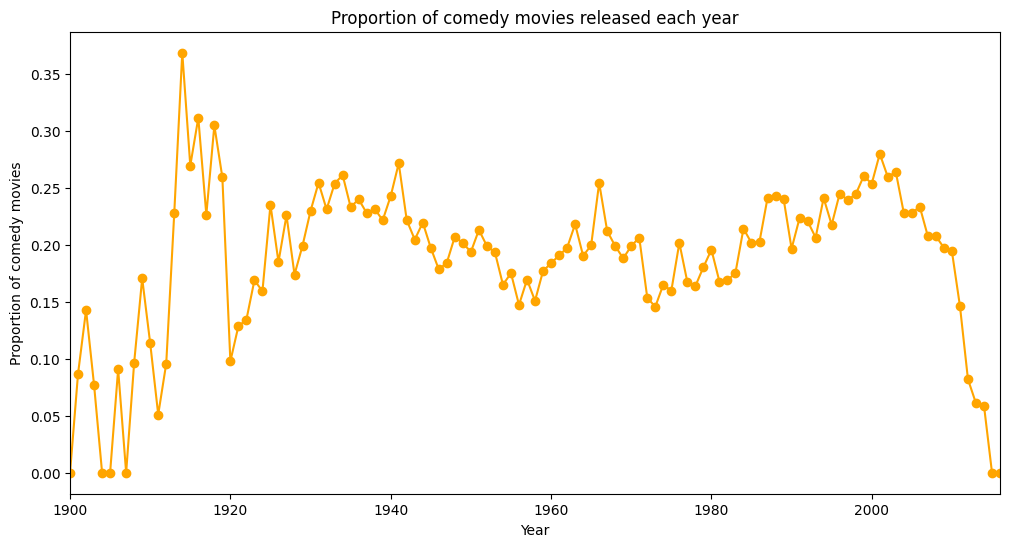

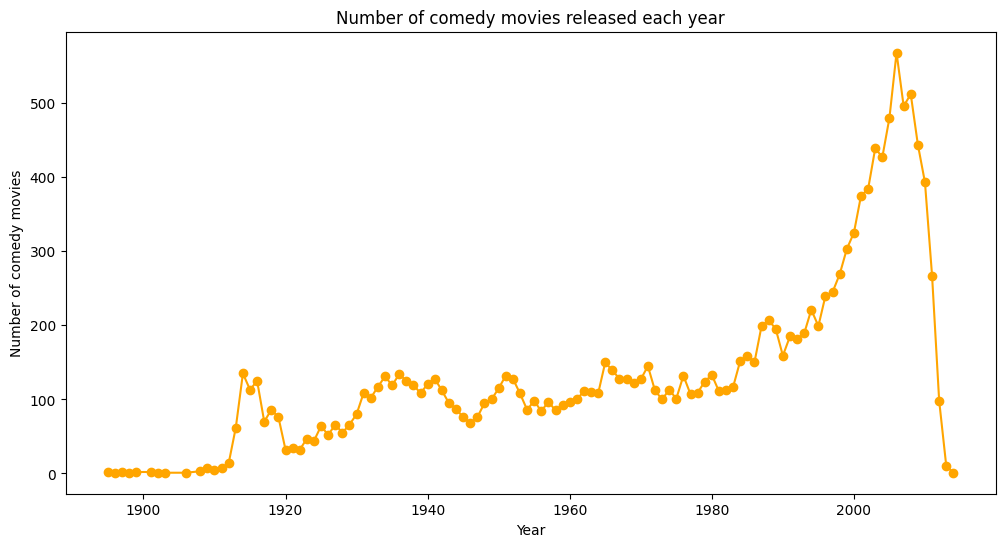

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(movies_per_year['release_date'], movies_per_year['comedy_proportion'], marker='o', color='orange', linestyle='-')
plt.title('Proportion of comedy movies released each year')
plt.xlabel('Year')
plt.ylabel('Proportion of comedy movies')
plt.xlim(movies_per_year['release_date'].min(), movies_per_year['release_date'].max())

plt.figure(figsize=(12, 6))
plt.plot(comedy_count_by_year['release_date'], comedy_count_by_year['comedy_count'], marker='o', color='orange', linestyle='-')
plt.title('Number of comedy movies released each year')
plt.xlabel('Year')
plt.ylabel('Number of comedy movies')

plt.show()

In [ ]:
total_movies_per_year.head()

,release_date,movie_count
0,1010.0,1
1,1888.0,1
2,1889.0,1
3,1890.0,2
4,1891.0,3


In [ ]:
comedies_exploded_countries = cmu_cleaned_movies.explode(column="countries",ignore_index=True)
comedies_exploded_countries["is_comedy"] = get_comedies_mask(comedies_exploded_countries)
country_movie_counts = comedies_exploded_countries.groupby('countries').agg(
    total_movies=('countries', 'size'),
    comedy_movies=('is_comedy', 'sum')
).reset_index()

print(country_movie_counts)

           countries  total_movies  comedy_movies
0        Afghanistan            15              0
1            Albania            28              2
2            Algeria            43              1
3          Argentina          1468            268
4            Armenia            16              3
..               ...           ...            ...
142  Weimar Republic            68              7
143     West Germany           647             93
144       Yugoslavia           306             41
145           Zambia             3              0
146         Zimbabwe             8              2

[147 rows x 3 columns]


In [ ]:
comedies_exploded_countries.head(5)

,wikipedia_id,freebase_id,title,release_date,box_office_revenue,runtime,languages,countries,genres,is_comedy
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],United States of America,"[Thriller, Science Fiction, Horror, Adventure,...",False
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],United States of America,"[Mystery, Biographical film, Drama, Crime Drama]",False
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],Norway,"[Crime Fiction, Drama]",False
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],United Kingdom,"[Thriller, Erotic thriller, Psychological thri...",False
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],Germany,[Drama],False
